# 第4週：對ptt與dcard上的鮭魚之亂議題進行情緒分析
**Author:** 蘇舫萱<br>
**Date created:** 2021/09/30<br>
**Last modified:** 2021/09/30<br>
本週課程為「情緒分析1」，目的為了解lexicon-base 情緒分析。情緒分析步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「中文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、資料前處理、lexicon-base 情緒分析

## 大綱
+ 1. 套件說明
+ 2. 資料前處理
    + 2.1 基本資料介紹
    + 2.2 資料清理
    + 2.3 文章斷詞
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒分數聲量折線圖圖
    + 3.4 正負向情緒分數比例折線圖圖
    + 3.5 文字雲
    + 3.6 情緒代表字
    + 3.7 情緒關鍵字
    + 3.8 與Dcard文集比較

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- re: 正規表達式套件。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。

In [1]:
# 安裝會使用到的套件
# %pip install wordcloud

In [2]:
# 確認當前工作目錄
%pwd

'/Users/changchiaming/Desktop/SMA_2021F/week4_sentiment_analysis1'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 

In [4]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

## 2. 資料前處理
從網路或twitter api取得的原始資料可能包含雜訊（多餘的空白、html標籤、網址等），在進行斷詞處理前應先進行資料清理。

## 2.1 基本資料介紹
- 資料來源: 文字平台收集PTT Gossip版2021-03-10 ~ 2021-03-31 所有文章
- 資料集： `raw_data/ptt_articleMetaData_0331.csv`
- 關鍵字：鮭、鮭魚、改名、壽司、壽司郎
- 資料時間：2021-03-09 ~ 2021-03-31 

主要分析ptt上網友的相關討論，並對比dcard上大家的討論情形。本次主要針對以下方向分析：
1. 鮭魚之亂的討論大概出現在哪個時間點，話題高峰在哪裡？
2. 正面和負面的討論內容各是甚麼，有沒有時間點上的差異？
3. 正面和負面討論的情緒分數大約多少？

In [5]:
#匯入資料
MetaData = pd.read_csv('./raw_data/ptt_articleMetaData_0331.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/ptt_articleReviews_0331.csv', encoding='UTF-8')

In [6]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(3)

共有 1809 篇文章


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]怎麼介紹台北的特色美食?,2021/3/9,17:24:58,https://www.ptt.cc/bbs/Gossiping/M.1615310700....,Emerson158,Gossiping,18,8,3,"首先,要說雙北也可以 台北市+新北市\n\nbtw,台北縣就台北縣 硬改名叫啥新北市,真是無..."
1,Re:[問卦]該接家業嗎？,2021/3/10,00:14:33,https://www.ptt.cc/bbs/Gossiping/M.1615335276....,foreverthink,Gossiping,1,0,0,接啊\n\n然後花點錢裝潢一下\n\n做過觀光工廠景點\n\n然後改名很潮的XXX工作室\n...
2,[問卦]共產主義是不是已經變質？,2021/3/10,04:05:29,https://www.ptt.cc/bbs/Gossiping/M.1615349131....,s72005ming,Gossiping,48,22,5,中國共產黨信奉的共產主義是不是已經變質？\n\n現在實施什麼中國特色的社會主義\n\n跟共產...


In [7]:
print(f"共有 {Reviews.shape[0]} 個留言")
Reviews.head(3)

共有 69735 個留言


,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,[問卦]怎麼介紹台北的特色美食?,2021/03/09,17:24:58,https://www.ptt.cc/bbs/Gossiping/M.1615310700....,Emerson158,Gossiping,chris44099,→,2021-03-10 01:26:00,:鼻涕粽啊
1,[問卦]怎麼介紹台北的特色美食?,2021/03/09,17:24:58,https://www.ptt.cc/bbs/Gossiping/M.1615310700....,Emerson158,Gossiping,jojoStar,噓,2021-03-10 01:29:00,:麥當勞KFCMOS還要我教?
2,[問卦]怎麼介紹台北的特色美食?,2021/03/09,17:24:58,https://www.ptt.cc/bbs/Gossiping/M.1615310700....,Emerson158,Gossiping,sherlockHQ,推,2021-03-10 01:33:00,:淡水阿給永和豆漿三峽金牛角福隆便當九份芋圓


In [8]:
# 再篩一次文章
keywords = ['鮭','免費壽司','免費吃壽司','免費的壽司','壽司郎','鮭魚之亂']
toMatch = '|'.join(keywords)


In [9]:
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(1495, 10)


In [10]:
# 挑選文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [11]:
print(Reviews.shape)
Reviews.head(3)

(61907, 10)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,:你一定沒吃過爭鮮的女店員
1,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,:樓下484甲甲
2,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,:可能是因為你是壽司初心者的緣故？


### 2.2 資料清理  
- 去除NA值
- 去除不是中文的字詞

In [12]:
# 移除cmtContent為na值的資料
Reviews.dropna(subset = ["cmtContent"], inplace=True)

In [13]:
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))

In [14]:
MetaData.head(3)
#MetaData['sentence']

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,安安阿肥我在爭鮮啦吃了盤快飽其中盤是鮭魚沒錯除了鮭魚其他都難吃不懂那些拿鮪魚拿手捲的人在想什...
1,[問卦]鮭魚煮熟為啥跟垃圾一樣？,2021/3/12,09:48:04,https://www.ptt.cc/bbs/Gossiping/M.1615542487....,frzqp3814396,Gossiping,37,8,10,鮭魚生魚片超好吃完全不雷但鮭魚不管煮湯還是用煎的怎麼吃起來就普普通通尤其魚腥味很難去除有沒有八卦
2,[問卦]雞蛋是素的為什麼魚卵是葷的???,2021/3/12,16:48:43,https://www.ptt.cc/bbs/Gossiping/M.1615567725....,eddisontw,Gossiping,11,3,1,很多人吃雞蛋都說雞蛋是素的因為沒有受精魚卵未產卵前也沒有受精阿像是鮭魚卵魚子醬明太子可是吃素...


In [15]:
Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))
Reviews.head(3)
#Reviews['cmtContent']

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,你一定沒吃過爭鮮的女店員
1,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,樓下甲甲
2,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,可能是因為你是壽司初心者的緣故


### 2.3 文章斷詞
中文文集我們使用`jjieba`套件進行斷詞與移除停用字

In [16]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /Users/changchiaming/Desktop/SMA_2021F/week4_sentiment_analysis1/dict/dict.txt.big ...
Loading model from cache /var/folders/p7/ypk0r_bd0wxc59khj3ph5msm0000gn/T/jieba.ua4e2dd727cf13af2f533c7cfc5d56995.cache
Loading model cost 1.146 seconds.
Prefix dict has been built successfully.


In [17]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [18]:
MetaData['word'] = MetaData.sentence.apply(getToken)

In [19]:
MetaData_token = MetaData.explode('word') # 將word欄位展開

In [20]:
MetaData_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,安安阿肥我在爭鮮啦吃了盤快飽其中盤是鮭魚沒錯除了鮭魚其他都難吃不懂那些拿鮪魚拿手捲的人在想什...,安安
0,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,安安阿肥我在爭鮮啦吃了盤快飽其中盤是鮭魚沒錯除了鮭魚其他都難吃不懂那些拿鮪魚拿手捲的人在想什...,阿肥
0,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,安安阿肥我在爭鮮啦吃了盤快飽其中盤是鮭魚沒錯除了鮭魚其他都難吃不懂那些拿鮪魚拿手捲的人在想什...,爭鮮


In [21]:
Reviews['word'] = Reviews.cmtContent.apply(getToken)

In [22]:
Reviews_token = Reviews.explode('word') # 將word欄位展開

In [23]:
Reviews_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,word
0,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,你一定沒吃過爭鮮的女店員,沒吃過
0,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,你一定沒吃過爭鮮的女店員,爭鮮
0,[問卦]爭鮮除了鮭魚是不是沒東西吃了,2021/3/10,10:40:11,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,aynmeow,Gossiping,20,8,2,你一定沒吃過爭鮮的女店員,女店員


In [24]:
# 合併斷詞後的本文與留言
data = pd.concat([MetaData_token.loc[:,["artDate","artUrl","word"]],Reviews_token.loc[:,["artDate","artUrl","word"]]],axis=0)
data.head()

,artDate,artUrl,word
0,2021/3/10,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,安安
0,2021/3/10,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,阿肥
0,2021/3/10,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,爭鮮
0,2021/3/10,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,鮭魚
0,2021/3/10,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,沒錯


In [25]:
#轉換日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y/%m/%d")

In [26]:
#計算每天不同字的詞頻
word_count = data.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head(10)

,artDate,word,size
46741,2021-03-19,鮭魚,1935
16648,2021-03-17,鮭魚,1928
9939,2021-03-17,改名,1590
37105,2021-03-19,改名,1577
28635,2021-03-18,鮭魚,1353
22395,2021-03-18,改名,1114
32392,2021-03-19,台灣,983
40923,2021-03-19,真的,910
55132,2021-03-20,鮭魚,620
5488,2021-03-17,免費,602


## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

## 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
- 分為正向情緒與負向情緒

In [27]:
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split(","),file])

In [28]:
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc

,word,sentiments
0,一無所有,negative
1,七竅生煙,negative
2,上當,negative
3,下流,negative
4,下等,negative
...,...,...
1706,魅力,positive
1707,鮮明,positive
1708,鮮美,positive
1709,鼓勵,positive


### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。可以先觀察每天的ptt文章數量，大約在3/15之後才比較有討論的聲量，並在3/18有最高聲量之後便開始下降。

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27599 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 22825 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 30332 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/back

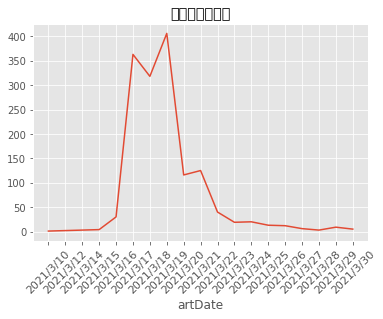

In [29]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

### 3.3 正負向情緒分數聲量折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [30]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size()
sentiment_count.head()

,artDate,sentiments,size
0,2021-03-10,negative,3
1,2021-03-10,positive,1
2,2021-03-12,negative,8
3,2021-03-12,positive,6
4,2021-03-14,negative,17


/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 36000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32210 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/ba

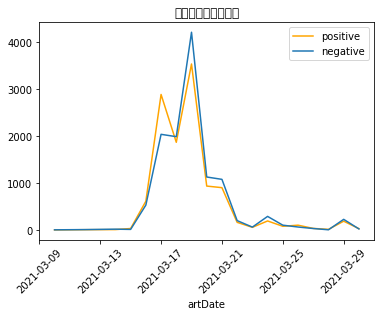

In [31]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒分數折線圖')
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('artDate')
plt.show()

畫出每天的情緒總分數，可以看到大概在3/18後，短短的幾天內，情緒從正面為主轉為負面為主。約在20號之後討論度逐漸下降

### 3.4 正負向情緒分數比例折線圖圖

In [32]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 36000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32210 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27604 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/ba

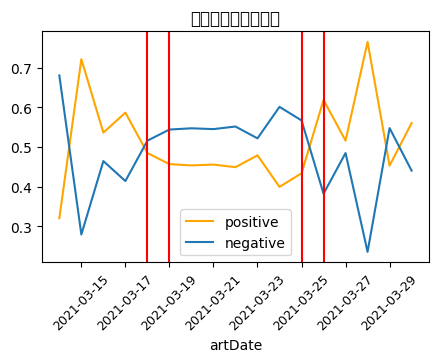

In [33]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] > '2021/03/13']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend() #顯示圖例
plt.axvline(x=datetime.strptime('2021-03-18', "%Y-%m-%d"), color="red", ls="-")
plt.axvline(x=datetime.strptime('2021-03-19', "%Y-%m-%d"), color="red", ls="-")
plt.axvline(x=datetime.strptime('2021-03-25', "%Y-%m-%d"), color="red", ls="-")
plt.axvline(x=datetime.strptime('2021-03-26', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artDate')
plt.show()

透過上圖我們可以發現3/18到3/19是一次情緒由正轉負的轉折，而3/25到3/26是一次情緒由負轉正的轉折

### 3.4 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [34]:
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('artDate == @Date') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict
    

### 2021-03-17 文字雲
2021-03-17的文字雲，往前看17正面情緒較高的文字雲，發現此時負面批評詞彙較少，出現較多正面詞彙或中性詞彙，如「笑死」、「年輕人」、「行銷」、「活動」、「廣告」，推測此時負面文章較少，網友對鮭魚事件仍持一種較為幽默的態度，覺得此企劃好笑、年輕人太衝動等。

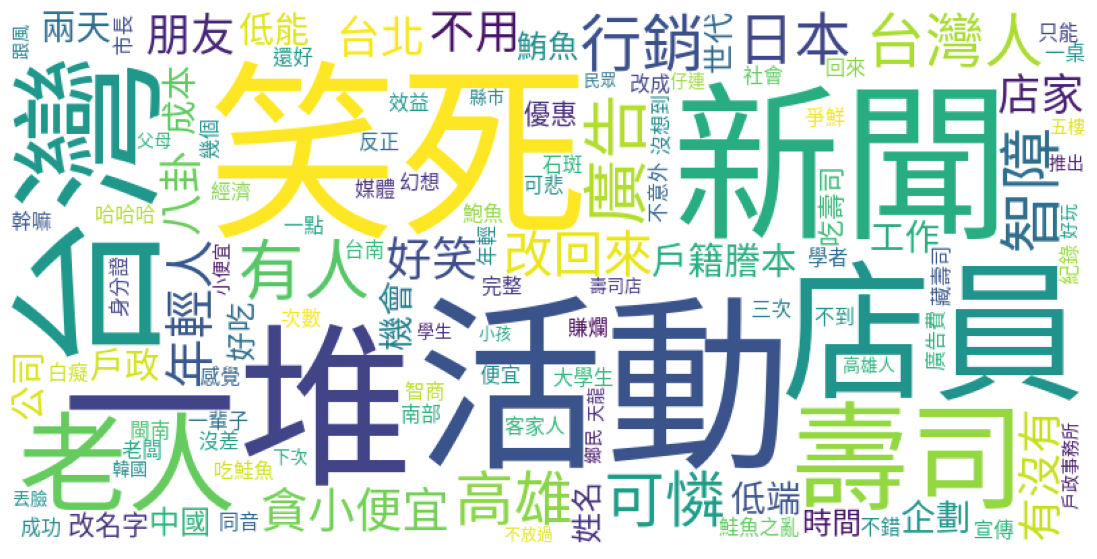

In [35]:
dict_0317 = Wc_dict(word_count,"2021-03-17",450,50)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_0317)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-03-19 文字雲
先從2021-03-19的情緒高點看起，呼應上面負面的情緒分析，出現「浪費」、「貪小便宜」、「丟臉」、「乞丐」等詞彙。推測是因許多網友抨擊改名行為不明智，也批評部分免費吃壽司的人造成食物浪費。  
而「新聞」、「日本」、「韓國」等詞，則是討論台灣鮭魚改名之亂引起國際媒體關注


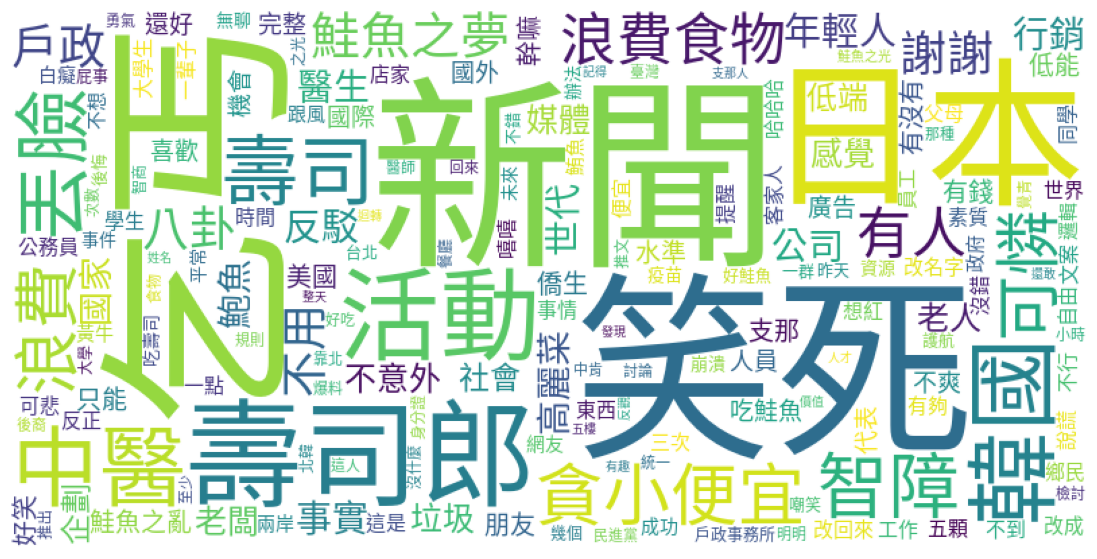

In [36]:
dict_0319 = Wc_dict(word_count,"2021-03-19",450,50)

wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_0319)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-03-21 文字雲
2021-03-21的文字雲，21號之後討論度開始下降  
出現「老闆」、「教授」、「違法」、「勞基法」等詞彙是因為出現有公司老闆以及教授宣稱若員工或學生改名成鮭魚就會開除，引發網友討論。  
而「日本」、「迴轉」等詞則是網友將壽司郎與其他迴轉壽司品牌進行比較

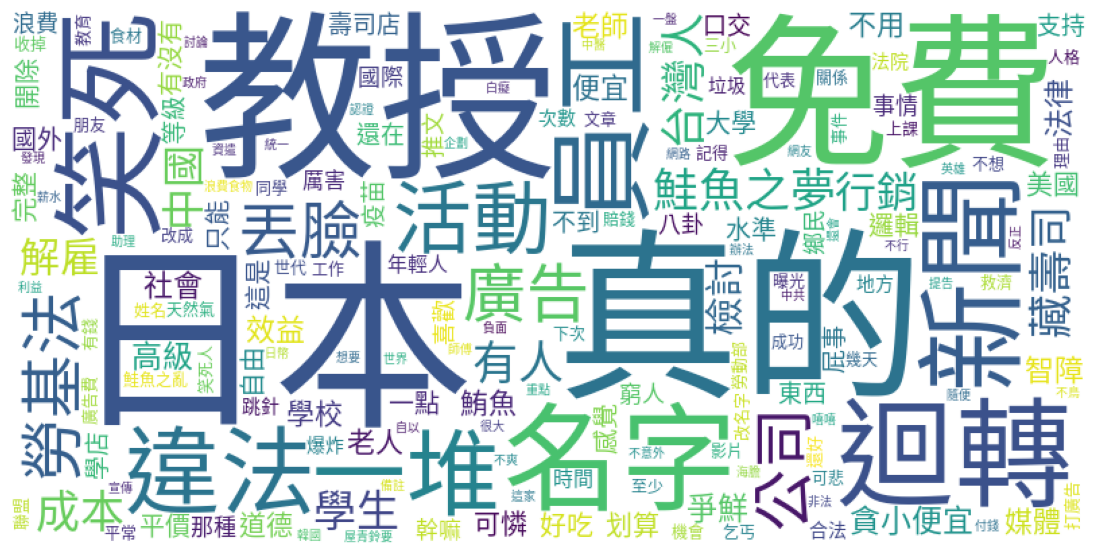

In [37]:
dict_0321 = Wc_dict(word_count,"2021-03-21",200,15)

wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_0321)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 3.5 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [38]:
sentiment_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

,word,sentiments,size
43,免費,positive,1851
254,笑死,positive,1399
187,智障,negative,818
73,可憐,negative,789
12,丟臉,negative,600


/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32210 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/ba

/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 40635 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 29033 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 38568 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 20415 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 24460 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.

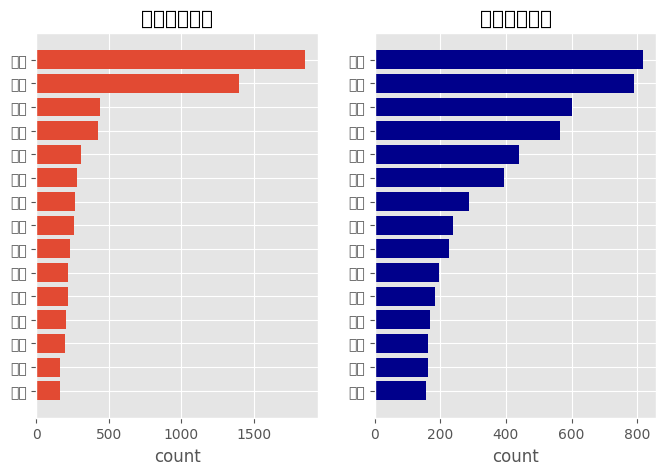

In [39]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

另外，也可以依據不同日期觀察情緒代表字的變化
### 2021-03-17 正負情緒代表字

In [40]:
sentiment_date_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['artDate', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選日期
sentiment_0317 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-03-17"].sort_values(by=['size'], ascending=False)
sentiment_0317.head()

,artDate,word,sentiments,size
81,2021-03-17,免費,positive,602
188,2021-03-17,笑死,positive,409
152,2021-03-17,智障,negative,204
91,2021-03-17,可憐,negative,197
111,2021-03-17,好笑,positive,146


/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32210 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/ba

/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 29245 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 20302 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 33021 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 20818 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 30333 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.

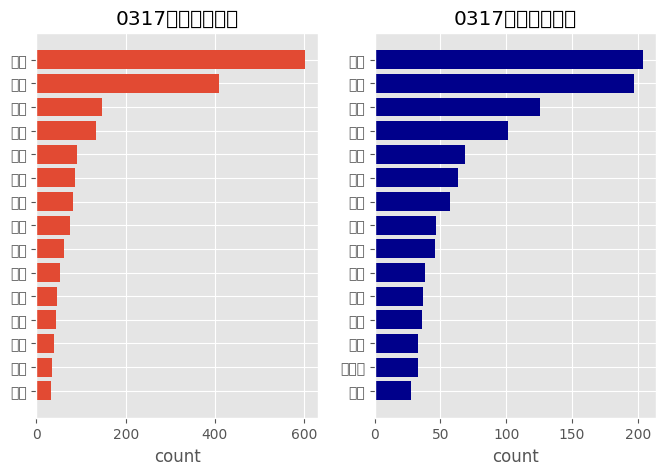

In [41]:
p_sum = sentiment_0317[sentiment_0317["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_0317[sentiment_0317["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('0317正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('0317負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 2021-03-19 正負情緒代表字

In [42]:
#篩選日期
sentiment_0319 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-03-19"].sort_values(by=['size'], ascending=False)
sentiment_0319.head()

,artDate,word,sentiments,size
436,2021-03-19,免費,positive,459
607,2021-03-19,笑死,positive,408
412,2021-03-19,丟臉,negative,306
556,2021-03-19,智障,negative,263
462,2021-03-19,可憐,negative,239


/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32210 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/ba

/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 24460 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 24724 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 28961 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 32842 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 30333 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.

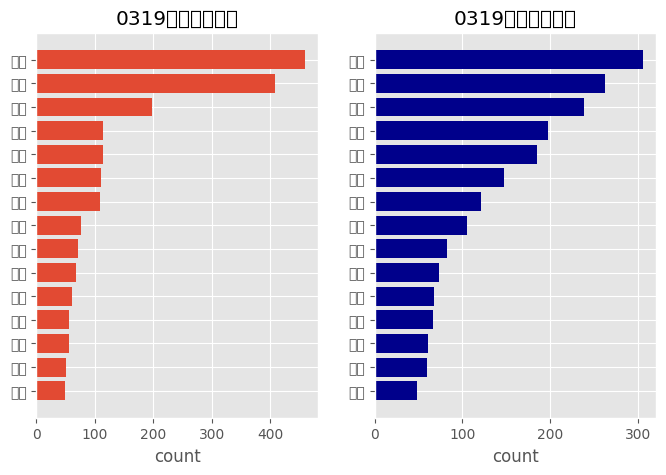

In [43]:
p_sum = sentiment_0319[sentiment_0319["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_0319[sentiment_0319["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('0319正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('0319負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

比較3/17和3/19的正負情緒代表字，可以發現在負面情緒的部分差異不大。  
在正面情緒部分3/17可以看到比較多「好笑」、「優惠」、「好吃」等詞，可以看出當時網友主要還是在討論優惠活動很有趣。  
而3/19有較多「謝謝」、「有錢」、「自由」等詞，主要是網友對於改名自由的討論和部分網友對改名的調侃。


## 3.6 歸類正負面文章
- 之前的情緒分析大部分是全部的詞彙加總，接下來將正負面情緒的文章分開，看看能不能發現一些新的東西。  
- 接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。

In [44]:
article_type = (data.merge(df_liwc, on='word')
                .groupby(['artUrl', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='artUrl', columns='sentiments', values='size', fill_value=0)
                .reset_index(['artUrl'])
               )
article_type.head()

sentiments,artUrl,negative,positive
0,https://www.ptt.cc/bbs/Gossiping/M.1615372814....,3,1
1,https://www.ptt.cc/bbs/Gossiping/M.1615542487....,5,6
2,https://www.ptt.cc/bbs/Gossiping/M.1615567725....,3,0
3,https://www.ptt.cc/bbs/Gossiping/M.1615691783....,0,1
4,https://www.ptt.cc/bbs/Gossiping/M.1615696977....,1,1


In [45]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,725
1,positive,693


### 正負情緒文章數量統計圖

In [46]:
article_type_date = article_type.merge(MetaData.loc[:,["artUrl", "artDate"]], how = 'left', on = 'artUrl')
article_type_date = article_type_date.groupby(['artDate','type'], as_index=False).size()
#article_type_date

/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 36000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32210 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/ba

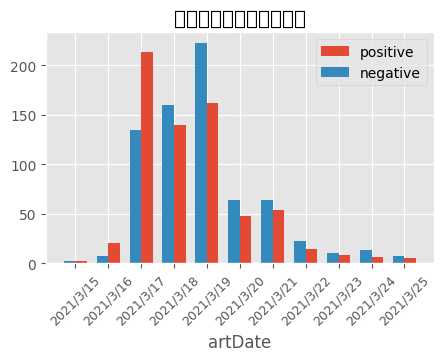

In [47]:
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2021/3/15")&(article_type_date["artDate"]<="2021/3/25")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2021/3/15")&(article_type_date["artDate"]<="2021/3/25")]

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

### 3.7 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併

In [48]:
positive_article = article_type[article_type["type"]=="positive"].merge(data, how = 'left', on = 'artUrl')
negative_article = article_type[article_type["type"]=="negative"].merge(data, how = 'left', on = 'artUrl')

### 情緒關鍵字:負面情緒文章

In [49]:
negative_article = (negative_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32210 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/ba

/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 39361 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 20302 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 33021 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 22403 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 22334 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.

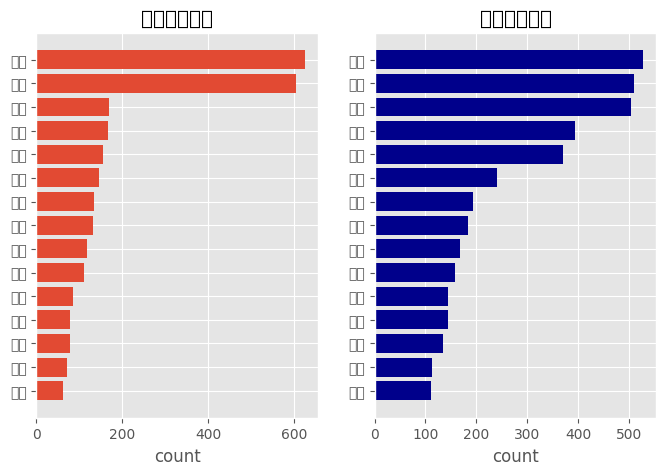

In [50]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 情緒關鍵字:正面情緒文章

In [51]:
positive_article = (positive_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32210 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/ba

/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 38556 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 36000 missing from current font.
  font.set_text(s, 0, flags=flags)


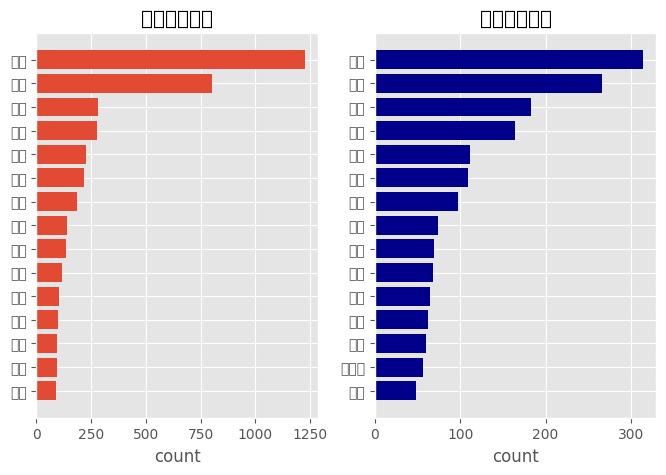

In [52]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

從正負面情緒圖觀察發現，正面和負面的關鍵字沒有甚麼顯著的差異，負面情緒較高的文章比較常出現「擔心」、「後悔」、「麻煩」等討論改名負面影響的字詞，比較著重在批評改名行為本身；正面情緒較高的文章出現較多的「免費」、「優惠」、「好玩」等字詞，著重在討論優惠本身。

## 3.8 與Dcard文集比較
我們另外準備了Dcard的資料集，搜尋條件與時間與ptt文集相同，想了不同的社群媒體對於同一個事件的情緒是否有差異。

In [53]:
Dcard = pd.read_csv('./raw_data/dcard_articleMetaData_0331.csv', encoding='UTF-8')

In [54]:
print(f"共有 {Dcard.shape[0]} 篇Dcard文章")
Dcard.head()

共有 222 篇Dcard文章


,artTitle,artDate,artTime,artUrl,sentence
0,ㄍㄨㄟ ㄩˊ,2021/03/15,12:20:44,https://www.dcard.tw/f/funny/p/235552161,最近看到壽司郎近期的優惠⬇️⬇️⬇️，https://i.imgur.com/csgRwkW...
1,有人叫鮭魚嗎？,2021/03/15,16:48:28,https://www.dcard.tw/f/funny/p/235553758,https://i.imgur.com/ZMebqSB.jpg，，今天網路上看到壽司郎在玩活...
2,壽司郎活動⋯⋯,2021/03/15,18:43:05,https://www.dcard.tw/f/funny/p/235554357,身為壽司郎愛好者的我，剛剛看到新聞報導有活動，欣喜若狂的點進去！！！！，結果⋯⋯，到底誰會叫...
3,ㄍㄨㄟ ㄩˊ 在哪裡,2021/03/15,19:13:05,https://www.dcard.tw/f/funny/p/235554529,https://i.imgur.com/7qNjNaE.jpg，乳圖，請問真的有人叫鮭魚嗎(...
4,壽司郎優惠,2021/03/15,19:34:34,https://www.dcard.tw/f/funny/p/235554668,如圖 ，如果名字叫「鮭魚」可以免費，是說到底有誰名字會是「鮭魚」啦，https://i.im...


In [55]:
Dcard['sentence'] = Dcard.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x)) # 對原始文章進行篩選，只留下中文字詞

In [56]:
Dcard['word'] = Dcard.sentence.apply(getToken) # 使用先前定義的斷詞與情除停用字function

In [57]:
DToken = Dcard.explode('word') # 展開斷詞結果

In [58]:
DToken["source"] = "Dcard" # 設定新欄位source
DToken['artDate'] = pd.to_datetime(DToken['artDate'], format="%Y/%m/%d")

PToken = data
PToken["source"] = "PTT" # 設定新欄位source

In [59]:
Dcard_senti_sum = (DToken.filter(["artDate","artUrl","word","source"])
                   .merge(df_liwc, on='word')
                   .groupby(['artDate', 'sentiments'], as_index=False)
                   .size()
                   .query('artDate >= "2021-03-15"'))

In [60]:
PTT_senti_sum = (PToken
                 .merge(df_liwc, on='word')
                 .groupby(['artDate', 'sentiments'], as_index=False)
                 .size()
                 .query('artDate >= "2021-03-15"'))

### ptt、dcard情緒分數比較

/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 31456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/test/lib/python3.8/site-packages/matplotlib/backends/ba

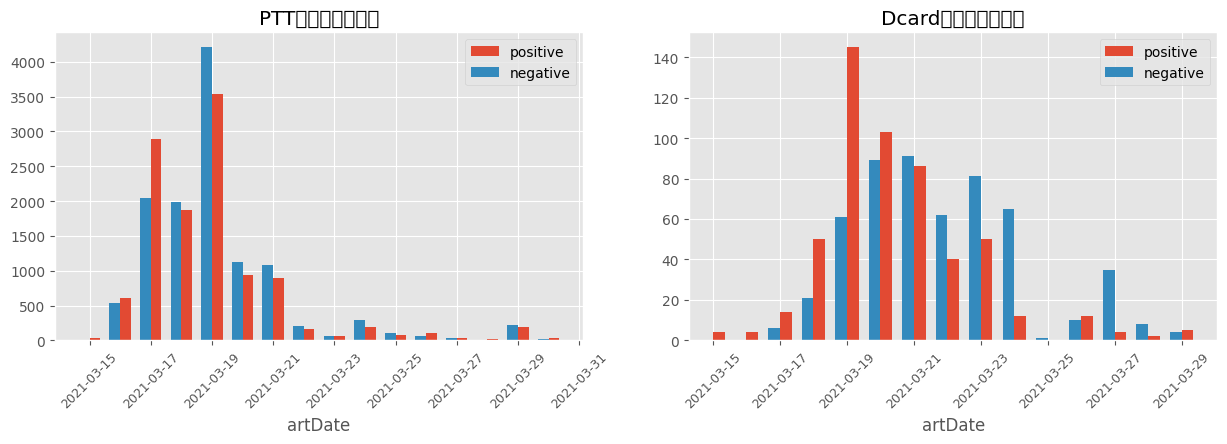

In [61]:
PTT_ap = PTT_senti_sum[PTT_senti_sum["sentiments"]=="positive"]
PTT_an = PTT_senti_sum[PTT_senti_sum["sentiments"]=="negative"]
Dcard_ap = Dcard_senti_sum[Dcard_senti_sum["sentiments"]=="positive"]
Dcard_an = Dcard_senti_sum[Dcard_senti_sum["sentiments"]=="negative"]

plt.figure(figsize=(15,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('PTT文章數量統計圖')
plt.xlabel('artDate')
plt.bar(PTT_ap['artDate'],PTT_ap['size'],align="edge",width=0.35,label="positive")
plt.bar(PTT_an['artDate'],PTT_an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')


plt.subplot(122)
plt.title('Dcard文章數量統計圖')
plt.xlabel('artDate')
plt.bar(Dcard_ap['artDate'],Dcard_ap['size'],align="edge",width=0.35,label="positive")
plt.bar(Dcard_an['artDate'],Dcard_an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

ptt和dcard的情緒分布直方圖，可以發現dcard相較於ptt正面情緒稍多，話題討論高峰的時間點也大致相同，但在dcard上的討論持續了比較久的時間。